## Regressor for boston housing dataset using pytorch

1.loading boston housing dataset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

# load the boston housing data and split it in to train and target data
boston = load_boston()
x_train, x_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

normalization

In [0]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

# normalization on train data
x_train_scaled = x_train - mean
x_train_scaled =x_train_scaled/std
# normalization on test data
x_test_scaled = x_test - mean
x_test_scaled /= std


min max normalization

In [0]:
# min-max normaization

# compute the min and max value per feature on the training set
min_on_training = x_train.min(axis=0)
max_on_training = x_train.max(axis=0)

# prevent divison by zero
norm_range = max_on_training - min_on_training
norm_range[norm_range == 0] = 1

# subtract the min, and divide by range
x_train_scaled = (x_train - min_on_training) / norm_range
x_test_scaled = (x_test - min_on_training) / norm_range


2.defining model architecture

In [0]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
class Regressor(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(Regressor, self).__init__()
        self.mlp=nn.Sequential(
            nn.Linear(inputSize,17),
            nn.ReLU(),
            nn.Linear(17,outputSize)
        )
        #self.linear = torch.nn.Linear(inputSize, outputSize)
        #self.Relu = torch.nn.ReLU()

    def forward(self, x):
        x_ = x.view(x.size(0),-1)
        out = self.mlp(x_)
        #x = self.Relu(x)
        #out = self.linear(x)
        return out

In [0]:
inputDim = 13        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 4000

model = Regressor(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [0]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

3. training the model

In [38]:
loss_item = []
loss_test = []

if torch.cuda.is_available():
    test_input = Variable(torch.from_numpy(x_test_scaled).cuda())
    test_label = Variable(torch.from_numpy(y_test).cuda())
else:
    test_input = Variable(torch.from_numpy(x_test_scaled))
    test_label = Variable(torch.from_numpy(y_test))
y_pred = model(test_input.float())
test_loss = criterion(y_pred, test_label.float())


for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train_scaled).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train_scaled))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs.float())
    test_output = model(test_input.float())

    #resize the label
    labels = labels.view(labels.size(0),-1)
    test_label = test_label.view(test_label.size(0),-1)


    # get loss for the predicted output
    loss = criterion(outputs, labels.float())
    loss1=criterion(test_output,test_label.float())

    loss_item.append(loss)
    loss_test.append(loss1)
    # get gradients w.r.t to parameters
    loss.backward()
    
    # update parameters
    optimizer.step()
    if epoch%10==0:
      print('epoch {}, loss {}, train r2 {}, test_r2 {}'.format(epoch, loss.item(),r2_score(y_train,outputs.detach().numpy()),r2_score(y_test,test_output.detach().numpy())))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([127, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 597.5408325195312, train r2 -6.0044916831774815, test_r2 -6.111472493643386
epoch 10, loss 546.7642211914062, train r2 -5.409278556667833, test_r2 -5.524869230016055
epoch 20, loss 456.876220703125, train r2 -4.3555932409419995, test_r2 -4.476917328968409
epoch 30, loss 326.55078125, train r2 -2.8278926971867344, test_r2 -2.986405838180806
epoch 40, loss 189.80633544921875, train r2 -1.2249474439782766, test_r2 -1.4452010603756906
epoch 50, loss 105.34386444091797, train r2 -0.2348616032029378, test_r2 -0.49328434087359896
epoch 60, loss 72.69058227539062, train r2 0.147906581230271, test_r2 -0.10829308563616702
epoch 70, loss 47.709537506103516, train r2 0.44073938180267536, test_r2 0.18729711095547785
epoch 80, loss 32.055599212646484, train r2 0.6242379283317833, test_r2 0.378076498038303
epoch 90, loss 25.58208465576172, train r2 0.7001217526088221, test_r2 0.4710428114014197
epoch 100, loss 22.718727111816406, train r2 0.733686594374305, test_r2 0.5233399083892478
ep

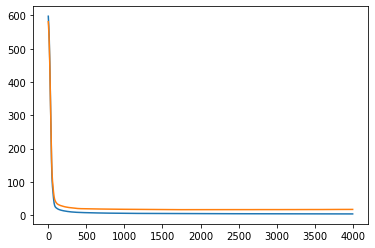

In [39]:
plt.plot(loss_item)
plt.plot(loss_test)

4. test the model

In [40]:
if torch.cuda.is_available():
    test_input = Variable(torch.from_numpy(x_test_scaled).cuda())
    test_label = Variable(torch.from_numpy(y_test).cuda())
else:
    test_input = Variable(torch.from_numpy(x_test_scaled))
    test_label = Variable(torch.from_numpy(y_test))
y_pred = model(test_input.float())
test_loss = criterion(y_pred, test_label.float())

print("prediction loss : ",test_loss)
print("r2 score : ",r2_score(y_test,y_pred.detach().numpy()))

prediction loss :  tensor(158.3354, grad_fn=<MseLossBackward>)
r2 score :  0.7888014412930328


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([127, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
print("answer : ",y_test[0:10])
print("prediction : ",y_pred[0:10].T)

answer :  [22.6 50.  23.   8.3 21.2 19.9 20.6 18.7 16.1 18.6]
prediction :  tensor([[24.0522, 26.3348, 24.6311, 11.7977, 20.6166, 19.9739, 22.7651, 22.1031,
         17.2671, 15.9400]], grad_fn=<PermuteBackward>)
